In [57]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal, Annotated
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv
from langchain_core.messages import SystemMessage, HumanMessage
import os
import operator
load_dotenv()

True

In [39]:
generator_llm = init_chat_model(model="google_genai:gemini-2.0-flash-lite", api_key=os.getenv("GOOGLE_API_KEY"))
evaluator_llm = init_chat_model(model="google_genai:gemini-2.5-flash", api_key=os.getenv("GOOGLE_API_KEY"))
optimizer_llm = init_chat_model(model="google_genai:gemini-2.5-flash-lite", api_key=os.getenv("GOOGLE_API_KEY"))

# State

In [60]:
class TweetState(TypedDict):
    topic: str
    tweet: str
    evaluation: Literal['approved', 'needs_improvement']
    feedback: str
    iteration: int
    max_iterations: int
    
    tweet_history: Annotated[list[str], operator.add]
    feedback_history: Annotated[list[str], operator.add]

# Schema for structured output

In [41]:
from pydantic import BaseModel, Field

class TweetEvaluation(BaseModel):
    evaluation: Literal['approved', 'needs_improvement'] = Field(..., description="Final Evaluation of the tweet")
    feedback: str = Field(..., descripmax_iterationtion="Feedback for the tweet")   

/tmp/ipykernel_56314/3666854677.py:5: PydanticDeprecatedSince20: Using extra keyword arguments on `Field` is deprecated and will be removed. Use `json_schema_extra` instead. (Extra keys: 'descripmax_iterationtion'). Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  feedback: str = Field(..., descripmax_iterationtion="Feedback for the tweet")


In [42]:
structured_evaluator_llm = evaluator_llm.with_structured_output(TweetEvaluation)

# Nodes (Function)

In [ ]:
def generate_tweet(state: TweetState):
    # prompt
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
                     Write a short, original, and hilarious tweet on the topic: "{state['topic']}".
                     
                     Rules:
                     - DO NOT use question-answer format.
                     - Max 280 characters.
                     - Use observational humor, irony, sarcasm, or cultural references.
                     - Think in meme logic, punchlines, or relatable takes.
                     - Use simple, day to day english.
                     - This is version {state['iteration'] + 1}
                     """)
    ]
    
    # send generator_llm
    response = generator_llm.invoke(messages).content
        
    # return response
    return{
        'tweet': response,
        'tweet_history': [response]
    }
    

In [ ]:
def evaluate_tweet(state: TweetState):
    # prompt
    messages = [
        SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
        HumanMessage(content=f"""
            Evaluate the following tweet:

            Tweet: "{state['tweet']}"

            Use the criteria below to evaluate the tweet:

            1. Originality - Is this fresh, or have you seen it a hundred times before?  
            2. Humor - Did it genuinely make you smile, laugh, or chuckle?  
            3. Punchiness - Is it short, sharp, and scroll-stopping?  
            4. Virality Potential - Would people retweet or share it?  
            5. Format - Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

            Auto-reject if:
            - It's written in question-answer format (e.g., "Why did..." or "What happens when...")
            - It exceeds 280 characters
            - It reads like a traditional setup-punchline joke
            - Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

            ### Respond ONLY in structured format:
            - evaluation: "approved" or "needs_improvement"  
            - feedback: One paragraph explaining the strengths and weaknesses 
    """)
    ]
    
    response = structured_evaluator_llm.invoke(messages)
    return{
        'evaluation': response.evaluation,
        'feedback': response.feedback,
        'feedback_history': [response.feedback]
    }  


In [45]:
def optimize_tweet(state: TweetState):
    # prompt 
    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
            Improve the tweet based on this feedback:
            "{state['feedback']}"

            Topic: "{state['topic']}"
            Original Tweet:
            {state['tweet']}

            Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
        """)
    ]
    
    response = optimizer_llm.invoke(messages).content
    iteration = state['iteration'] + 1
    
    return{
        'tweet': response,
        'iteration': iteration
    }

# Conditional edge (function)

In [55]:
def route_evaluation(state: TweetState):
    if state['evaluation'] == 'approved' or state['iteration'] >= state['max_iterations']:
        return 'approved'
    else:
        return 'needs_improvement'

# Graph

In [51]:
graph = StateGraph(TweetState)

# NODE
graph.add_node("generate", generate_tweet)
graph.add_node("evaluate", evaluate_tweet)
graph.add_node("optimize", optimize_tweet)

graph.add_edge(START, 'generate')
graph.add_edge('generate', 'evaluate')
graph.add_conditional_edges('evaluate', route_evaluation, {'approved': END, 'needs_improvement': 'optimize'})
graph.add_edge('optimize', 'evaluate')

workflow = graph.compile()


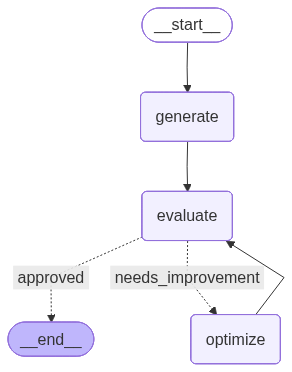

In [52]:
workflow

In [53]:
initial_state = {
    'topic': 'Graph database usecase',
    'iteration': 1,
    'max_iterations': 5
}

In [54]:
workflow.invoke(initial_state)

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 0, model: gemini-2.0-flash-lite
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 0, model: gemini-2.0-flash-lite
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_input_token_count, limit: 0, model: gemini-2.0-flash-lite
Please retry in 1.561591374s. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "g

KeyboardInterrupt: 